# 모듈, 데이터 가져오기


In [ ]:
# 모듈
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error,roc_auc_score,roc_curve
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [ ]:
# 버전확인
import sklearn
sklearn.__version__

'0.23.2'

In [ ]:
# id 컬럼은 인덱스 정도 의미
train      = pd.read_csv( '/content/drive/MyDrive/cloud_ai/모듈_프로젝트_2/ep.2/res/train (1).csv', index_col='id' )
test       = pd.read_csv( '/content/drive/MyDrive/cloud_ai/모듈_프로젝트_2/ep.2/res/test (1).csv', index_col='id' )
submission = pd.read_csv( '/content/drive/MyDrive/cloud_ai/모듈_프로젝트_2/ep.2/res/sample_submission (1).csv', index_col='id' )

In [ ]:
train.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0


In [ ]:
test.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
15304,Female,57.0,0,0,Yes,Private,Rural,82.54,33.4,Unknown
15305,Male,70.0,1,0,Yes,Private,Urban,72.06,28.5,Unknown


In [ ]:
train.shape, test.shape, submission.shape

((15304, 11), (10204, 10), (10204, 1))

In [ ]:
test.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
15304,Female,57.0,0,0,Yes,Private,Rural,82.54,33.4,Unknown
15305,Male,70.0,1,0,Yes,Private,Urban,72.06,28.5,Unknown


In [ ]:
# 타입 확인
train.dtypes
# gender, ever_married, work_type, Residence_type, smoking_status => 문자형
# age, hypertension, heart_disease, avg_glucose_level, bmi, stroke => 수치형                         , 

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [ ]:
# test 데이터를 예측해서 submission의 stroke 컬럼에 채운다
submission.columns
submission.head(), submission.stroke.unique()

(         stroke
 id             
 15304  0.041296
 15305  0.041296
 15306  0.041296
 15307  0.041296
 15308  0.041296, array([0.04129639]))

In [ ]:
# 결측치 없음, 고유값 개수 확인
train.isnull().sum().values, train.nunique().values

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([   3,  106,    2,    2,    2,    5,    2, 3740,  407,    4,    2]))

# 데이터 준비 + EDA (분석, 피처엔지니어링 대상및 처리내용 체크)

## 피처 요약 함수 구성 - 차후 계속 사용(업그레이드)

In [ ]:
def summary_feature_info( df, train=train ):
    '''
      # 피처 요약 정보 생성하는 함수 구성 -> 피처를 빠르게 파악할수 있다
      # 전체 데이터 : 볼륨(형상) -> print()
      # 피처별 : 피처명, 타입,  결측치수, 고유값수, 샘플값0~2(0,1,2개정도) => DF로 구성 출력
      # 피처를 파악해 보겠다
    '''
    sum_df = pd.DataFrame( train.dtypes, columns=['type'])   
    # 인덱스 -> 컬럼으로 이동
    sum_df = sum_df.reset_index()
    # 컬럼명 index -> feature_name 변경
    sum_df.rename( columns={ 'index':'feature_name' }, inplace=True)

    # 결측치수
    sum_df['결측치수'] = train.isnull().sum().values

    # 고유값수
    sum_df['고유값수'] = train.nunique().values

    # 샘플값0~2(0,1,2개정도)
    sum_df['샘플값0'] = train.loc[0].values
    sum_df['샘플값1'] = train.loc[1].values
    sum_df['샘플값2'] = train.loc[2].values

    return sum_df

summary_df = summary_feature_info( train )
summary_df

,feature_name,type,결측치수,고유값수,샘플값0,샘플값1,샘플값2
0,gender,object,0,3,Male,Male,Female
1,age,float64,0,106,28.0,33.0,42.0
2,hypertension,int64,0,2,0,0,0
3,heart_disease,int64,0,2,0,0,0
4,ever_married,object,0,2,Yes,Yes,Yes
5,work_type,object,0,5,Private,Private,Private
6,Residence_type,object,0,2,Urban,Rural,Rural
7,avg_glucose_level,float64,0,3740,79.53,78.44,103.0
8,bmi,float64,0,407,31.1,23.9,40.3
9,smoking_status,object,0,4,never smoked,formerly smoked,Unknown


## 피처 요약 기준 해석및 전략 수립

### 문자형

- gender, ever_married, work_type, Residence_type, smoking_status 

In [ ]:
# 고유값 확인
train['gender'].unique()             # gender         : ['Male', 'Female', 'Other']  => Other를 Male or Female로 변경해야할듯?
train['ever_married'].unique()       # ever_married   : ['Yes', 'No']
train['work_type'].unique()          # work_type      : ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']
train['Residence_type'].unique()     # Residence_type : ['Urban', 'Rural']
train['smoking_status'].unique()     # smoking_status : ['never smoked', 'formerly smoked', 'Unknown', 'smokes']

# 문자형 데이터는 수치형 데이터로 변환해야한다

array(['never smoked', 'formerly smoked', 'Unknown', 'smokes'],
      dtype=object)

In [ ]:
# 성별 카운트
pd.crosstab(
    index=train['gender'],
    columns='gd_cnts'
)
# Other 값이 하나기 때문에 Male or Female로 변경

col_0,gd_cnts
gender,
Female,9446
Male,5857
Other,1


In [ ]:
# Other 값이 존재하는 행 찾기
train[train['gender'].str.contains('Other')]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9363,Other,9.0,0,0,No,children,Rural,96.04,18.0,Unknown,0


In [ ]:
# Other 값을 Male로 변경
train.loc[9363, 'gender'] = 'Male'
train['gender'].unique()  # => Other가 Male로 바뀐것을 알 수 있다

array(['Male', 'Female'], dtype=object)

### 수치형

- age, hypertension, heart_disease, avg_glucose_level, bmi, stroke

In [ ]:
train['age'].describe()                # age               : 범주형?
train['hypertension'].unique()         # hypertension      : [0, 1]
train['heart_disease'].unique()        # heart_disease     : [0, 1]
train['avg_glucose_level'].describe()  # avg_glucose_level : 범주형?
train['bmi'].describe()                # bmi               : 범주형?
# train['stroke'].unique()             # stroke            : [0, 1]

count    15304.000000
mean        28.112721
std          6.722315
min         10.300000
25%         23.500000
50%         27.600000
75%         32.000000
max         80.100000
Name: bmi, dtype: float64

In [ ]:
num_cols = ['age', 'avg_glucose_level', 'bmi']
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension','heart_disease']
cat_cols_v1 = ['gender', 'ever_married', 'Residence_type', 'hypertension', 'heart_disease']   # 이진 피처
cat_cols_v2 = ['work_type', 'smoking_status']  # 피처 고유값 3개 이상

## 데이터 시각화를 통한 분석

### 타겟(정답) 값 분포

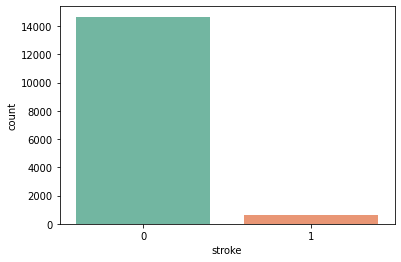

In [ ]:
sns.countplot( data=train, x='stroke' );
# 둘 사이에 비율 => 0의 개수 / 1의 개수 

In [ ]:
# 타겟값 1에 비해 타겟값 0은 23.215배 많이 분포한다 
# -> 범주형변수의 고유값별로 타겟값의 비율을 유지하는가? (어느정도)
c0, c1 = np.unique( train.stroke.values,  return_counts=True)[1]
c0 / c1

23.21518987341772

타겟값간 비율 23.21518987341772


Text(0.5, 1.0, 'Stroke Value Distribution')

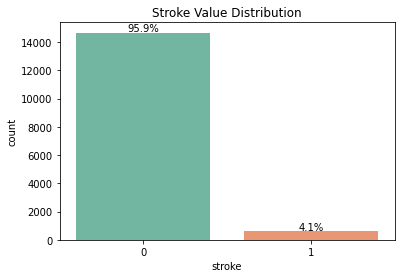

In [ ]:
# 향후 시각화 자료에 비율을 표기하는 부분을 추가 => 텍스트 드로잉
def show_text_percent_by_stroke( ax, total_count, is_show=True,  ):
  '''
    is_show : True일대만 텍스트가 노출되게 처리
    ax : 텍스트를 그리고자 하는 차트의 축정보
    total_count : 전체 카운트수
  '''
  persents = list()         # 비율을 담는 그릇
  # 카운트 플롯 차트상에 개별 박스 정보를 구하는 방법 -> ax.patches

  # 카운트 플롯 차트상에서 순차적으로 박스를 하나식 추출한다
  for patch in ax.patches: # 차트상에 존재하는 모든 형태의 도형을 차례대로 추출하는 연속형 변수
    w = patch.get_width()  # 타겟값 0 혹은 1, 카운트 플롯의 개별 박스 너비
    h = patch.get_height() # 타겟값 0 혹은 1의 카운트수 -> 카운트 플롯의 개별 박스 높이->카운트
    p = h/total_count * 100 # 타깃값의 비율 = (개별박스의 높이(카운트) / 전체카운트)*100
    persents.append( p )
    # 텍스트 그리기
    # 좌표 정보 획득
    l = patch.get_x()    # 도형 왼쪽 테투리 X축의 기준 위치값    
    ax.text(  x=l + w/2,  # 도형의 정 가운데를 X축 좌표
              y=h + total_count*0.005, # 1, total_count(가변값)의 특정 비율로 올려서 위치를 조정
              s=f'{p:1.1f}%', # 타겟값의 비율을 개별 차트내 도형 위에 그려지는 내용 ex) 38.8%
              ha='center'    # 정렬(가운데)
            )
  if is_show:
    if len(persents) == 2:   # 타겟용
      print( '타겟값간 비율', persents[0]/persents[1] )
    elif len(persents) == 4: # 이진 피처용
      # print( persents )
      # 타겟값에 맞춰서 도형이 그려진다 0번 타겟이 먼저 그려지고, 1번 타겟이 나중에 그려진다
      print( persents[0]/persents[2], persents[1]/persents[3] )
  pass

ax = sns.countplot( data=train, x='stroke');
show_text_percent_by_stroke( ax, train.shape[0] )
ax.set_title('Stroke Value Distribution')

### 이진형 피처 분포

21.189393939393938 24.668478260869566


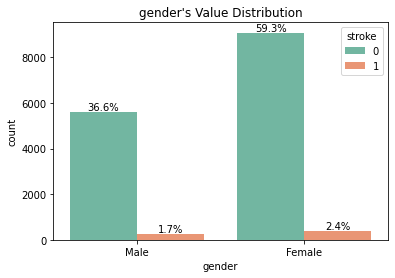

16.57191201353638 118.97560975609757


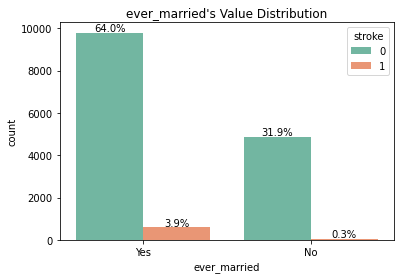

23.253968253968253 23.176656151419557


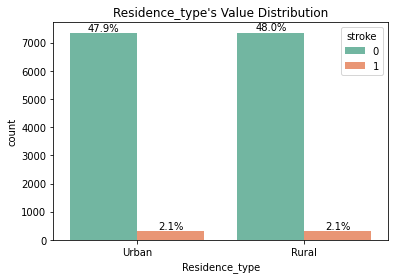

27.855158730158724 4.945312500000001


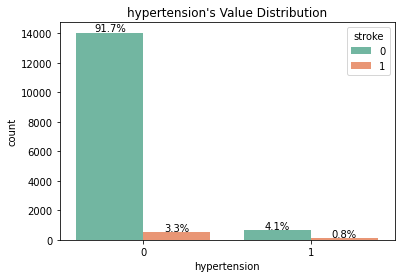

25.40812720848057 4.409090909090908


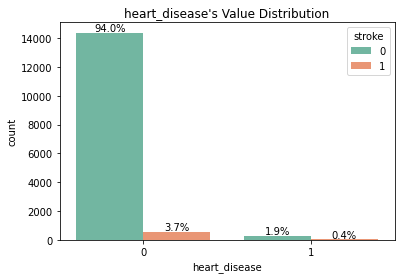

In [ ]:
cat_cols_v1 = ['gender', 'ever_married', 'Residence_type', 'hypertension', 'heart_disease']   # 이진 피처
for cat_col_v1 in cat_cols_v1:

  ax = sns.countplot( data=train, x=cat_col_v1, hue='stroke' );
  show_text_percent_by_stroke( ax, train.shape[0] )
  ax.set_title(f'{ cat_col_v1 }\'s Value Distribution')
  plt.show()

  # gender         : 남성보다 여성의 발병률이 더 높다
  # ever_married   : 기혼자의 발병률이 미혼자의 발병률보다 더 높다
  # Residence_type : 주거지역(도시, 시골)에 따른 발병률의 차이는 없는 것으로 보인다 => 굳이 필요한 데이터? 제거하는게 좋을 것 같다
  # hypertension   : 뇌졸중 환자 중 고혈압이 있는 사람보다 없는 사람이 더 많다
  # heart_disease  : 뇌졸중 환자 중 심장병이 있는 사람보다 없는 사람이 더 많다

### 명목형 피처 분포

In [ ]:
# cat_cols_v2 = ['work_type', 'smoking_status']

pd.crosstab( train['work_type'], train['stroke'] )
# 카운트 표현 

stroke,0,1
work_type,,
Govt_job,1464,69
Never_worked,42,0
Private,9348,404
Self-employed,1781,158
children,2037,1


In [ ]:
# 백분율로 표현
# normalize 옵션 지정 => index or column을 지정하면 해당 기준으로 백분율 처리
cross_tab = pd.crosstab( train['work_type'], train['stroke'] , normalize='index' ) * 100
cross_tab

stroke,0,1
work_type,,
Govt_job,95.499022,4.500978
Never_worked,100.000000,0.000000
Private,95.857260,4.142740
Self-employed,91.851470,8.148530
children,99.950932,0.049068


In [ ]:
# 함수화
def make_cross_tab( df , feature_name ):
  cross_tab = pd.crosstab( df[feature_name], df['stroke'], normalize='index' ) * 100
  cross_tab.reset_index( inplace=True )
  return cross_tab

cross_tab_v1 = make_cross_tab( train, 'work_type' )
cross_tab_v2 = make_cross_tab( train, 'smoking_status' )

In [ ]:
cross_tab_v1

stroke,work_type,0,1
0,Govt_job,95.499022,4.500978
1,Never_worked,100.000000,0.000000
2,Private,95.857260,4.142740
3,Self-employed,91.851470,8.148530
4,children,99.950932,0.049068


In [ ]:
cross_tab_v2

stroke,smoking_status,0,1
0,Unknown,97.622716,2.377284
1,formerly smoked,93.196406,6.803594
2,never smoked,95.908295,4.091705
3,smokes,94.960336,5.039664


#### 포인트 플롯 


- 정답 1에 대한 비율 포인트를 찍고, 포인트를 연결
- 이것을 통해 추세를 확인, **차이 확인(구분이되는가)**

In [ ]:
cross_tab.columns

Int64Index([0, 1], dtype='int64', name='stroke')

In [ ]:
def show_pointplot(id,cross_tab, color, ax=None):
  if ax:
    sns.pointplot( x= id ,            # 피처값
                  y= 1,            # 정답 1에 대한 포인트 플롯
                  data=cross_tab,  # 그리는 대상 df 
                  order= cross_tab[id],          # 포인트 플롯 순서 
                  color=color,     # 그리는 색상
                  ax=ax
                  );
show_pointplot_v1 = show_pointplot('work_type', cross_tab_v1, 'blue')
show_pointplot_v2 = show_pointplot('smoking_status', cross_tab_v2, 'blue')

#### 카운트 플롯 + 한개의 함수로 구성

In [ ]:
import matplotlib.gridspec as gridspec # 격자 배치용

0.723292469352014 1.0905272981801213


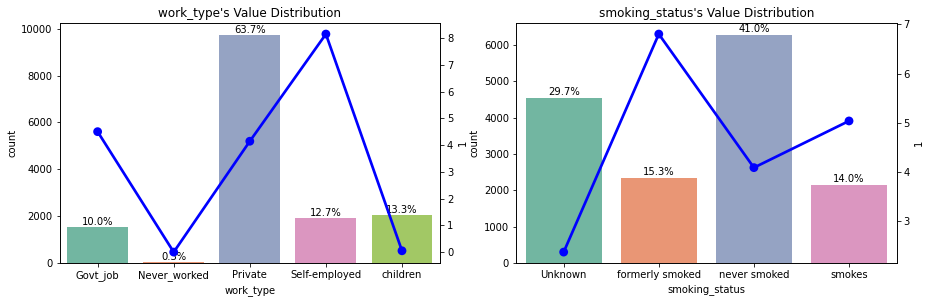

In [ ]:
# cat_cols_v2 = ['work_type', 'smoking_status']
def show_count_point_plot( all_data, features, rows=3, cols=2 ):
  # 1개의 차트에 격자로 분할 -> 각 자리에 ax를 전달 -> 이것을 이용하여 그린다
  plt.figure( figsize=(15, 15) ) # 그리면서 조정 : 세로 3칸, 가로 2칸
  # 서브플롯 배치 
  p_grid = gridspec.GridSpec(rows, cols)  # 3줄, 2칸 => 차트 5개 => 피처가 5개

  for idx, feature in enumerate( features ):
    ax = plt.subplot( p_grid[idx] )
    cross_tab = make_cross_tab( all_data, feature )
    # order를 사용 했으면 한차트에 사용되는 모든 함수는 같은 순서(order) 유지 해야 동일하게 배치됨
    sns.countplot( data=all_data, x=feature, ax=ax, order=cross_tab[feature] )  # ax=ax : 격자 안에서 특정 위치로 차트가 세팅
    show_text_percent_by_stroke( ax, all_data.shape[0] )
    ax.set_title(f'{ feature }\'s Value Distribution')
    show_pointplot( feature, cross_tab, 'blue', ax.twinx() )
  plt.show()  

show_count_point_plot( train, cat_cols_v2 )

# work_type      : 발병률은 Self-employed, Govt_job, Private work_type, children, Never_worked 순으로 높다
# smoking_status : 발병률은 formerly smoked, smokes, never smoked, Unknown 순으로 높다

### 수치형 피처 분포

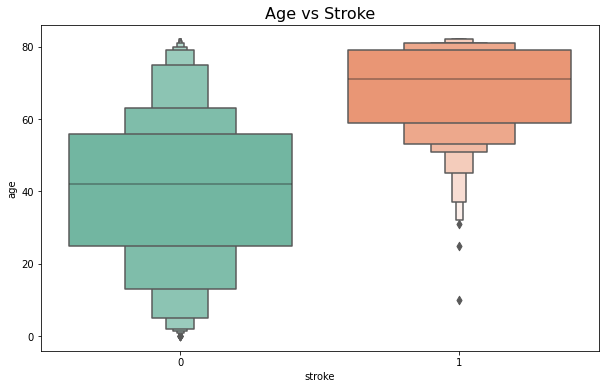

In [ ]:
# age 피처
plt.figure(figsize=(10, 6))

sns.set_palette('Set2')

ax = sns.boxenplot(data=train, x='stroke', y='age')
ax.set_title('Age vs Stroke', fontdict={'fontsize': 16})
plt.show()

# 뇌졸중이 있는 관측치의 대부분이 60세 이상인 반면 뇌졸중이 없는 관측치의 대부분은 60 미만이라는 것을 명확하게 볼 수 있다. 이 기능은 좋은 예측 변수가 될 수 있습니다.

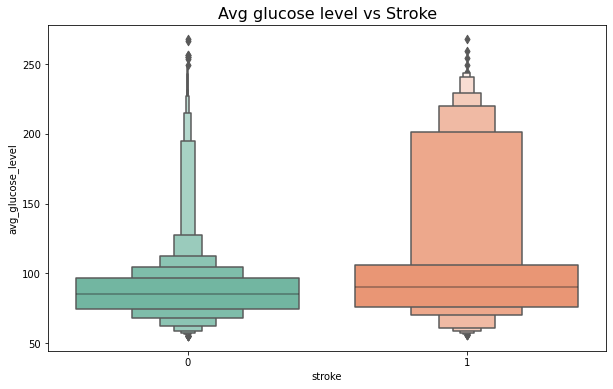

In [ ]:
# avg_glucose_level 피처
plt.figure(figsize=(10, 6))

sns.set_palette('Set2')

ax = sns.boxenplot(data=train, x='stroke', y='avg_glucose_level')
ax.set_title('Avg glucose level vs Stroke', fontdict={'fontsize': 16})
plt.show()

# 포도당 수치가 높을수록 뇌졸중에 걸릴 확률이 높다

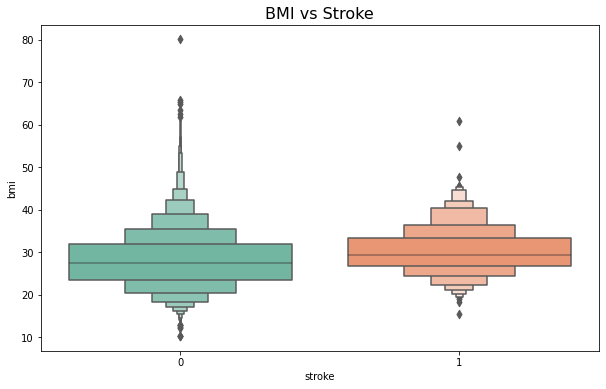

In [ ]:
# bmi 피처
plt.figure(figsize=(10, 6))

sns.set_palette('Set2')

ax = sns.boxenplot(data=train, x='stroke', y='bmi')
ax.set_title('BMI vs Stroke', fontdict={'fontsize': 16})
plt.show()

# Though many of observations with a negative stroke case have a lower bmi, 
# it does seem to have a huge impact on the target variable because there are some observations who have too high bmi but still have a negative stroke case.
# 눈에 띄는 차이는 보이지 않는다. 굳이 필요할 데이터일까?

## EDA 분석 결과

- 문자형 데이터 수치형으로 변환(인코딩) 해야함
- 타겟값 기준 23.215배

# 데이터 전처리

In [ ]:
# 오리지널 데이터 불러오기
df_orig = pd.read_csv('/content/drive/MyDrive/cloud_ai/모듈_프로젝트_2/ep.2/res/healthcare-dataset-stroke-data.csv', index_col=0)
# Because in the dataset, there are many observations with a stroke value of 0, 
# but a few observations with a stroke value of 1, we will combine only those rows from the original data that have a stroke of 1.
# 데이터 집합에는 stroke 값이 0인 관측치가 많지만 stroke 값이 1인 관측치가 몇 개 있기 때문에 stroke 1인 원래 데이터의 행만 결합합니다.

In [ ]:
df_orig

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


In [ ]:
# training set이랑 결합
df_orig_stroke_1 = df_orig[df_orig[['stroke']].all(1)]
df_orig_stroke_1

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
17739,Male,57.0,0,0,Yes,Private,Rural,84.96,36.7,Unknown,1
49669,Female,14.0,0,0,No,children,Rural,57.93,30.9,Unknown,1
27153,Female,75.0,0,0,Yes,Self-employed,Rural,78.80,29.3,formerly smoked,1


In [ ]:
# added_train = pd.concat( [train, df_orig_stroke_1] )
added_train = pd.concat( [train, df_orig_stroke_1] )
added_train.shape

(15553, 11)

In [ ]:
added_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status,stroke
id,,,,,,,,,
0,Male,28.0,0,0,Yes,Private,79.53,never smoked,0
1,Male,33.0,0,0,Yes,Private,78.44,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,103.00,Unknown,0
3,Male,56.0,0,0,Yes,Private,64.87,never smoked,0
4,Female,24.0,0,0,No,Private,73.36,never smoked,0


In [ ]:
# 'Residence_type'과 'bmi' 피처들은 모델에 도움이 될 것 같지 않다 => 삭제
added_train = added_train.drop(['Residence_type', 'bmi'], axis=1)

In [ ]:
added_train.shape

(15553, 9)

# 모델 구축

## 피처엔지니어링

- 최종 학습한 데이터 형태 준비
  - 인코딩
  - 스케일링
  - 피처 제거, 파생변수, 결측값 처리, 이상값 제거,..

- num_cols = ['age', 'avg_glucose_level', 'bmi(삭제)']
- cat_cols_v1 = ['gender', 'ever_married', 'Residence_type'(삭제), 'hypertension', 'heart_disease']
- cat_cols_v2 = ['work_type', 'smoking_status']

### 인코딩

In [ ]:
num_cols = ['age', 'avg_glucose_level']
cat_cols_v1 = ['gender', 'ever_married', 'hypertension', 'heart_disease']
cat_cols_v2 = ['work_type', 'smoking_status']

In [ ]:
# 변환 처리 map() => 해당값에 일치되는 키가 발견되면 그 값으로 대체한다
added_train[ cat_cols_v1[0] ] = added_train[ cat_cols_v1[0] ].map( {'Male':1, 'Female':0})
added_train[ cat_cols_v1[1] ] = added_train[ cat_cols_v1[1] ].map( {'Yes':1 , 'No':0})
added_train[ cat_cols_v2[0] ] = added_train[ cat_cols_v2[0] ].map( {'Private':0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4}) #.astype('int')
added_train[ cat_cols_v2[1] ] = added_train[ cat_cols_v2[1] ].map( {'never smoked' : 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown': 3}) #.astype('int')

In [ ]:
added_train.shape

(15553, 9)

### 피처 스케일링

In [ ]:
added_train.head(5)
# age, avg_glucose_level에 대해 피처 스케일링이 필요해보인다(MinMaxScaler)

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status,stroke
id,,,,,,,,,
0,1,28.0,0,0,1,0,79.53,0,0
1,1,33.0,0,0,1,0,78.44,1,0
2,0,42.0,0,0,1,0,103.00,3,0
3,1,56.0,0,0,1,0,64.87,0,0
4,0,24.0,0,0,0,0,73.36,0,0


In [ ]:
scaler = MinMaxScaler()
added_train[['age', 'avg_glucose_level']] = scaler.fit_transform(added_train[['age', 'avg_glucose_level']])
added_train.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status,stroke
id,,,,,,,,,
0,1,0.340820,0,0,1,0,0.112276,0,0
1,1,0.401855,0,0,1,0,0.107242,1,0
2,0,0.511719,0,0,1,0,0.220672,3,0
3,1,0.682617,0,0,1,0,0.044569,0,0
4,0,0.291992,0,0,0,0,0.083780,0,0
